# **Import Libraries**

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
import tensorflow.keras as k
from tensorflow.keras.applications.resnet50 import ResNet50
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
import time

# **Parameters**

    Define the batch size
    Define the class (category) names

In [2]:
BATCH_SIZE = 32 
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Define some functions that will help us to create some visualizations.

In [3]:
#Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# utility to display a row of digits with their predictions
def display_images(digits, predictions, labels, title):

  n = 10

  indexes = np.random.choice(len(predictions), size=n)
  n_digits = digits[indexes]
  n_predictions = predictions[indexes]
  n_predictions = n_predictions.reshape((n,))
  n_labels = labels[indexes]
 
  fig = plt.figure(figsize=(20, 4))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])

  for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    class_index = n_predictions[i]
    
    plt.xlabel(classes[class_index])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(n_digits[i])

# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(history.history[metric_name],color='blue',label=metric_name)
  plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

# **Loading and Preprocessing Data**

CIFAR-10 dataset has 32 x 32 RGB images belonging to 10 classes. We will load the dataset from Keras.

In [4]:
(training_images, training_labels) , (validation_images, validation_labels) = tf.keras.datasets.cifar10.load_data()

# **Visualize Dataset**

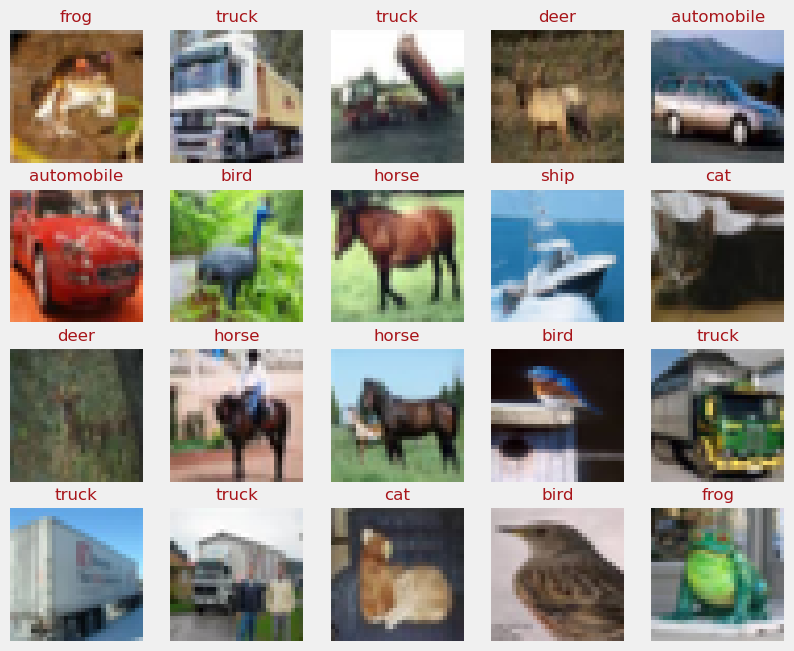

In [5]:
train_ds=tf.data.Dataset.from_tensor_slices((training_images,training_labels))
test_ds=tf.data.Dataset.from_tensor_slices((validation_images,validation_labels))

plt.figure(figsize=(10,10))
for i,(image,label) in enumerate(train_ds.take(20)):
    #print(label)
    ax=plt.subplot(5,5,i+1)
    plt.imshow(image)
    plt.title(classes[label.numpy()[0]])
    plt.axis('off')
#display_images(training_images, training_labels, training_labels, "Training Data" )

# **Preprocess Dataset**

In [6]:
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output_ims

In [7]:
train_X = preprocess_image_input(training_images)
valid_X = preprocess_image_input(validation_images)

# **Define the Network**
We will be performing transfer learning on ResNet50 available in Keras.

    We'll load pre-trained imagenet weights to the model.
    We'll choose to retain all layers of ResNet50 along with the final classification layers.

In [8]:
'''
Feature Extraction is performed by ResNet50 pretrained on imagenet weights. 
Input size is 224 x 224.
'''
def feature_extractor(inputs):

  feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
  return feature_extractor


'''
Defines final dense layers and subsequent softmax layer for classification.
'''
def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

'''
Since input image size is (32 x 32), first upsample the image by factor of (7x7) to transform it to (224 x 224)
Connect the feature extraction and "classifier" layers to build the model.
'''
def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

'''
Define the model and compile it. 
Use Stochastic Gradient Descent as the optimizer.
Use Sparse Categorical CrossEntropy as the loss function.
'''
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  
  classification_output = final_model(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
 
  model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model


model = define_compile_model()

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              209817

# **Train the model**

Epoch 1/5
782/782 [==============================] - 332s 390ms/step - loss: 0.3923 - accuracy: 0.8722 - val_loss: 0.2314 - val_accuracy: 0.9204
Epoch 2/5
782/782 [==============================] - 301s 385ms/step - loss: 0.1005 - accuracy: 0.9671 - val_loss: 0.2307 - val_accuracy: 0.9244
Epoch 3/5
782/782 [==============================] - 300s 384ms/step - loss: 0.0347 - accuracy: 0.9901 - val_loss: 0.1831 - val_accuracy: 0.9444
Epoch 4/5
782/782 [==============================] - 302s 386ms/step - loss: 0.0147 - accuracy: 0.9965 - val_loss: 0.1806 - val_accuracy: 0.9482
Epoch 5/5
782/782 [==============================] - 300s 384ms/step - loss: 0.0067 - accuracy: 0.9988 - val_loss: 0.1669 - val_accuracy: 0.9542


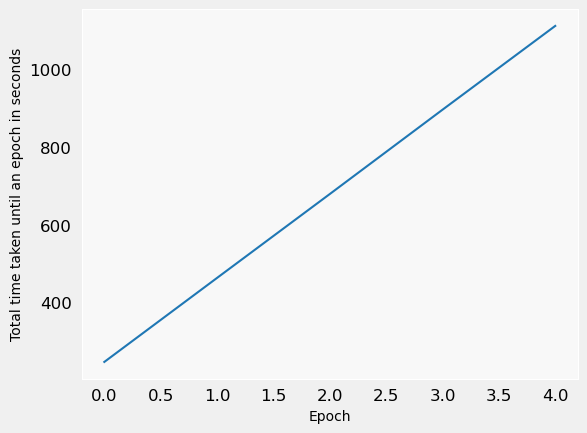

Epoch  0  run time is:  245.809258522
Epoch  1  run time is:  216.748653165
Epoch  2  run time is:  216.39867284299999
Epoch  3  run time is:  217.559977625
Epoch  4  run time is:  216.17747604800002
Total trained time is:  1112.694038203


In [9]:
class timecallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.times = []
        # use this value as reference to calculate cumulative time taken
        self.timetaken = time.process_time()
    def on_epoch_end(self,epoch,logs = {}):
        self.times.append((epoch, time.process_time() - self.timetaken))
    def on_train_end(self,logs = {}):
        plt.xlabel('Epoch')
        plt.ylabel('Total time taken until an epoch in seconds')
        plt.plot(*zip(*self.times))
        plt.show()
        from operator import itemgetter
        previous_time = 0
        for item in self.times:
            print("Epoch ", item[0], " run time is: ", item[1]-previous_time)
            previous_time = item[1]
        print("Total trained time is: ", previous_time)

timetaken = timecallback()
callbacks = [
    # This callback saves a SavedModel every epoch
    # We include the current epoch in the folder name.
    k.callbacks.ModelCheckpoint(
        filepath=os.path.join(os.getcwd(), "ckpt-{epoch}"), save_freq="epoch"
    ),
    timetaken
]

EPOCHS = 5
history = model.fit(train_X, training_labels, epochs=EPOCHS, validation_data = (valid_X, validation_labels), batch_size=64, callbacks=callbacks)

# **Evaluate the Model**

In [10]:
loss, accuracy = model.evaluate(valid_X, validation_labels, batch_size=64)

157/157 [==============================] - 15s 94ms/step - loss: 0.1669 - accuracy: 0.9542


# **Plot Loss and Accuracy Curves**

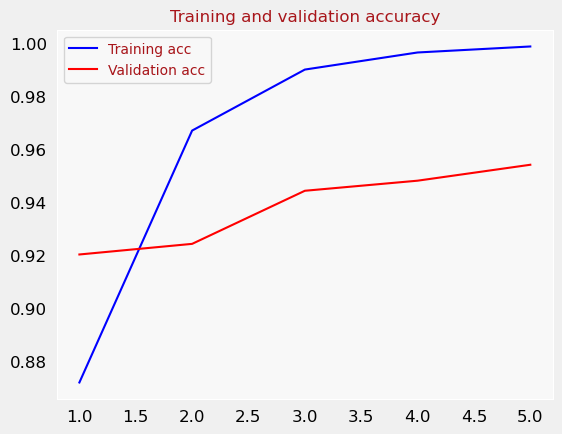

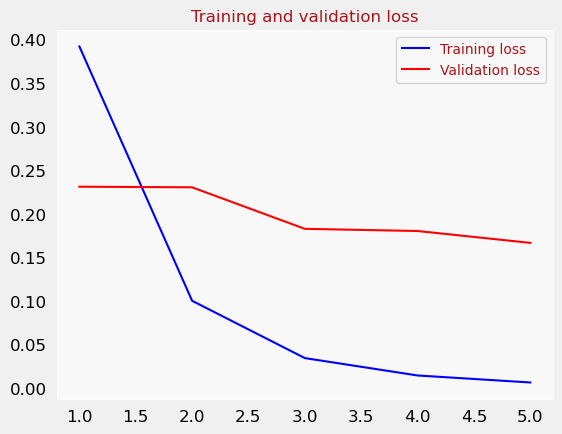

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()